## Validation on reconstructed images
#### The main steps:
1) Load tiles and corresponding labels into dictionary data format
2) Set up the best model (from the performed experiments) and run on the validation tiles
3) Process the predictions (we want to have [x_min, y_min, x_max, y_max, confidence, class_index] format)
4) Save predictions to the existing dictionary (from step 1)
5) Perform image-wide data reconstruction and remove overlapping labels/predictions using NMS
6) Visualize results and calculte validation metrics

In [1]:
import os
import sys
import time
import warnings
import json

import numpy as np
import cv2
import torch
from torch import amp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Ensure plots are displayed inline in the notebook
%matplotlib inline

from util.tile_dictionary import tiles_labels_to_dictionary
from util.boxes import decode_output
from util.reconstruction import reconstruct_data
from util.metrics import process_json

warnings.filterwarnings("ignore", category=FutureWarning, message=r"`torch.cuda.amp.autocast\(args\.\.\.\)` is deprecated")

#### Setup output directory

In [2]:
OUTPUT_DIR = 'val_output'

# Delete output directory if it exists
if os.path.exists(OUTPUT_DIR):
    os.system(f'rm -r {OUTPUT_DIR}')

# Create output directory if it does not exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

#### Initialize validation paths and class labels

In [3]:
# Paths for validation images and labels
VAL_IMAGE_PATH = os.path.join('val_data', 'valid', 'images')
VAL_LABEL_PATH = os.path.join('val_data', 'valid', 'labels')

# Class labels
CLASS_LABELS = ["Defective", "Speckled", "Beaded","Clear", "Unknown"]

# Class colors in BGR format
CLASS_COLORS = [
    (56, 56, 255),   # Red (Class 0)
    (151, 157, 255), # Light Red (Class 1)
    (31, 112, 255),  # Orange (Class 2)
    (29, 178, 255),  # Yellow (Class 3)
    (100, 205, 50)   # Green (Class 4)
]

#### Load tiles and labels into a dictionary

In [4]:
# Load tiles and annotation labels
tiles_with_labels = tiles_labels_to_dictionary(tile_dir = VAL_IMAGE_PATH, label_dir = VAL_LABEL_PATH)

#### Setup YOLOv5 model

In [5]:
# Weights from the best performed model
YOLO_WEIGHTS = 'particles_best.pt'

model = torch.hub.load("ultralytics/yolov5", "custom", path=YOLO_WEIGHTS)

Using cache found in /home/greta/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-8 Python-3.12.3 torch-2.4.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24217MiB)

Fusing layers... 
Model summary: 267 layers, 46129818 parameters, 0 gradients, 107.7 GFLOPs
Adding AutoShape... 


#### Model inference on validation tiles and data reconstruction

In [6]:
# Run the model on the validation tiles
for base_name, data in tiles_with_labels.items():

    # Get the image
    tile = data["tile"]

    # Get image dimensions
    h, w, _ = tile.shape

    # Convert image to tensor, normalize and add batch dimension
    tile = torch.from_numpy(tile).cuda()
    tile = tile.float() / 255.0
    tile = tile.permute(2, 0, 1).unsqueeze(0)

    # Use autocast for mixed precision
    with amp.autocast("cuda"):
        output = model(tile)

    # Convert the image back to numpy array and scale to 0-255
    tile = tile.squeeze().permute(1, 2, 0).cpu().numpy() * 255.0

    # Decode the output to get bounding boxes
    boxes = decode_output(output, conf=0.8)

    # Add predcitions to the dictionary
    tiles_with_labels[base_name]["predictions"] = boxes

# Reconstruct the image and labels
reconstruct_data(tiles_with_labels, image_size=(1080, 1920, 3), stride = 220, class_colors=CLASS_COLORS, class_labels=CLASS_LABELS, output_dir=OUTPUT_DIR)

Results saved in val_output/results.json


#### Load reconstructed images with labels and predictions (for side-by-side comparison)


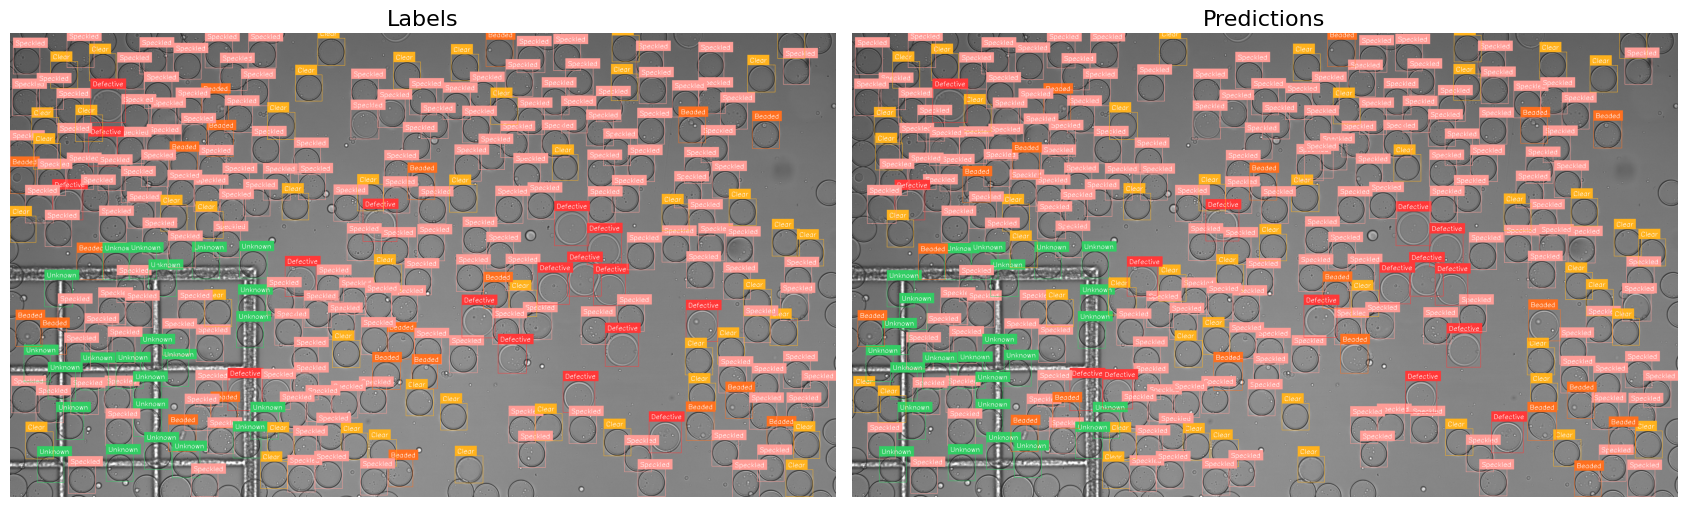

In [10]:
%matplotlib inline
# Provide image paths
# To double-check the reconstruction process is enough to load one pair of image with labels and predictions
image_paths = [f"{OUTPUT_DIR}/0_gt.png", f"{OUTPUT_DIR}/0_pred.png"]

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(17, 17))

# Loop through the images and subplots
for i, img_path in enumerate(image_paths):
    # Load the image using cv2 (OpenCV loads images as BGR)
    img = cv2.imread(img_path)
    
    # Convert the image from BGR to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Show the image in the subplot
    axs[i].imshow(img_rgb)
    
    # Remove axis ticks
    axs[i].axis('off')
    
    # Add custom text based on index: "Labels" for the left image, "Predictions" for the right
    if i == 0:
        axs[i].text(0.5, 1.05, "Labels", fontsize=16, color='k', ha='center', va='top', transform=axs[i].transAxes)
    else:
        axs[i].text(0.5, 1.05, "Predictions", fontsize=16, color='k', ha='center', va='top', transform=axs[i].transAxes)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Compute validation metrics

In [9]:
# Load JSON data from a file
with open('val_output/results.json', 'r') as f:
    json_data = json.load(f)

# Apply function that uses data in json file to calulate validation metrics
process_json(json_data, CLASS_LABELS)

Image 1 - Precision: 0.8475, Recall: 0.8475
Class counts for image 1:
Defective  Labels: 8     Predictions: 13   
Speckled   Labels: 60    Predictions: 56   
Beaded     Labels: 84    Predictions: 80   
Clear      Labels: 25    Predictions: 28   
Unknown    Labels: 0     Predictions: 0    
--------------------

Image 0 - Precision: 0.8764, Recall: 0.8669
Class counts for image 0:
Defective  Labels: 17    Predictions: 15   
Speckled   Labels: 170   Predictions: 167  
Beaded     Labels: 21    Predictions: 19   
Clear      Labels: 47    Predictions: 49   
Unknown    Labels: 23    Predictions: 25   
--------------------

Image 2 - Precision: 0.8980, Recall: 0.8907
Class counts for image 2:
Defective  Labels: 15    Predictions: 15   
Speckled   Labels: 101   Predictions: 88   
Beaded     Labels: 2     Predictions: 1    
Clear      Labels: 40    Predictions: 49   
Unknown    Labels: 89    Predictions: 92   
--------------------

